In [31]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

Importer des données

In [32]:

data=pd.read_csv("./one_room_apartement.csv")

In [33]:
data.head()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
0,1.995,20.863,6.004,273.935,1.726,23.718,805.0,490.458,1868,518.956,...,758.0,27.774,0.923,26.690,60.385,0.04,12.983,51.839,5.402,859.499
1,1.689,20.863,6.891,296.490,1.726,23.715,806.0,490.505,1867,520.396,...,715.0,27.762,0.739,26.594,60.377,0.03,12.980,52.092,6.451,932.282
2,2.854,20.863,7.486,268.740,1.726,23.716,808.0,489.080,1857,520.139,...,742.0,27.764,3.002,26.501,60.358,0.00,12.977,51.313,6.107,851.850
3,1.635,20.862,5.874,262.821,1.726,23.719,807.0,488.189,1881,518.782,...,746.0,27.748,1.287,26.611,60.426,0.03,12.993,53.420,5.489,829.355
4,1.579,20.864,7.068,297.597,1.725,23.712,809.0,485.401,1880,516.398,...,717.0,27.760,0.527,26.681,60.435,0.03,12.990,52.284,6.723,926.864


In [34]:
data.tail()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
12441,2.493,20.842,3.159,139.359,1.578,27.999,738.0,432.277,1799,715.633,...,661.0,32.491,0.652,30.628,47.086,0.00,12.860,59.537,2.733,432.119
12442,2.550,20.843,2.592,151.838,1.577,28.029,738.0,433.938,1782,723.661,...,653.0,32.507,0.590,30.105,47.237,0.08,12.923,59.008,2.277,475.226
12443,2.020,20.840,3.614,163.927,1.575,28.074,741.0,435.733,1804,733.135,...,650.0,32.559,1.847,29.544,47.292,0.31,12.970,59.580,3.254,520.100
12444,2.970,20.841,2.830,130.268,1.573,28.110,746.0,432.326,1799,739.224,...,654.0,32.575,1.636,29.012,47.268,0.36,12.989,59.275,2.154,408.629
12445,5.349,20.840,3.612,122.472,1.573,28.149,745.0,433.729,1786,747.578,...,648.0,32.597,3.106,28.614,47.254,0.23,13.013,59.092,1.747,381.507


Les données sont de 12445x31 et nous devons filtrer les valeurs nulles et les paramètres de mesure qui ne nous concernent pas.

In [35]:
print(data)

       TypPS  oxygen   pm10   cnt0_5     co  temperature  performance  \
0      1.995  20.863  6.004  273.935  1.726       23.718        805.0   
1      1.689  20.863  6.891  296.490  1.726       23.715        806.0   
2      2.854  20.863  7.486  268.740  1.726       23.716        808.0   
3      1.635  20.862  5.874  262.821  1.726       23.719        807.0   
4      1.579  20.864  7.068  297.597  1.725       23.712        809.0   
...      ...     ...    ...      ...    ...          ...          ...   
12441  2.493  20.842  3.159  139.359  1.578       27.999        738.0   
12442  2.550  20.843  2.592  151.838  1.577       28.029        738.0   
12443  2.020  20.840  3.614  163.927  1.575       28.074        741.0   
12444  2.970  20.841  2.830  130.268  1.573       28.110        746.0   
12445  5.349  20.840  3.612  122.472  1.573       28.149        745.0   

           co2  measuretime      so2  ...  health  temperature_o2 cnt2_5  \
0      490.458         1868  518.956  ...   758

**Nettoyage des données**

Supprimer les lignes nulles et les colonnes de caractéristiques inintéressantes

In [36]:
data.drop(['TypPS', 'cnt0_5','cnt1','performance','measuretime','temperature_o2','sound_max','cnt5','cnt10','dCO2dt','health','cnt2_5','o3','humidity_abs','dHdt','cnt0_3'], axis=1, inplace=True)
data.dropna(inplace=True)
data['timestamp'] = pd.to_datetime(data['timestamp'])
dates_to_remove = ['2023-07-09']
dates_to_remove = pd.to_datetime(dates_to_remove)
data = data[~data['timestamp'].dt.normalize().isin(dates_to_remove)]
columns = list(data.columns)
columns.remove('temperature')
columns.remove('pressure')
columns.remove('humidity')
columns.extend(['temperature', 'pressure', 'humidity'])

data = data[columns]

Modifier le nom de timestamp et le convertir en index

In [37]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

timestamp_col = data.pop('timestamp')
data.insert(0, 'date', timestamp_col)

data = data.set_index(['date'])

print(data.tail(10))

                     oxygen   pm10     co      co2      so2     no2    pm1  \
date                                                                         
2023-07-11 10:31:33  20.842  2.670  1.585  428.491  675.899   1.144  1.836   
2023-07-11 10:33:36  20.841  2.372  1.585  431.928  684.438   1.672  2.022   
2023-07-11 10:35:34  20.840  2.424  1.584  437.313  688.993   2.797  2.145   
2023-07-11 10:37:38  20.839  2.162  1.582  436.153  700.038   4.932  1.852   
2023-07-11 10:39:38  20.840  2.336  1.580  434.915  714.911   6.322  1.730   
2023-07-11 10:41:40  20.842  3.159  1.578  432.277  715.633   7.023  2.007   
2023-07-11 10:43:40  20.843  2.592  1.577  433.938  723.661   8.350  1.668   
2023-07-11 10:45:42  20.840  3.614  1.575  435.733  733.135   9.782  2.233   
2023-07-11 10:47:41  20.841  2.830  1.573  432.326  739.224  10.519  1.955   
2023-07-11 10:49:42  20.840  3.612  1.573  433.729  747.578  10.959  1.507   

                      dewpt      tvoc   sound  pm2_5  temperatu

Présenter l'évolution de la valeur de la mesure qui nous intéresse au cours de l'échantillon

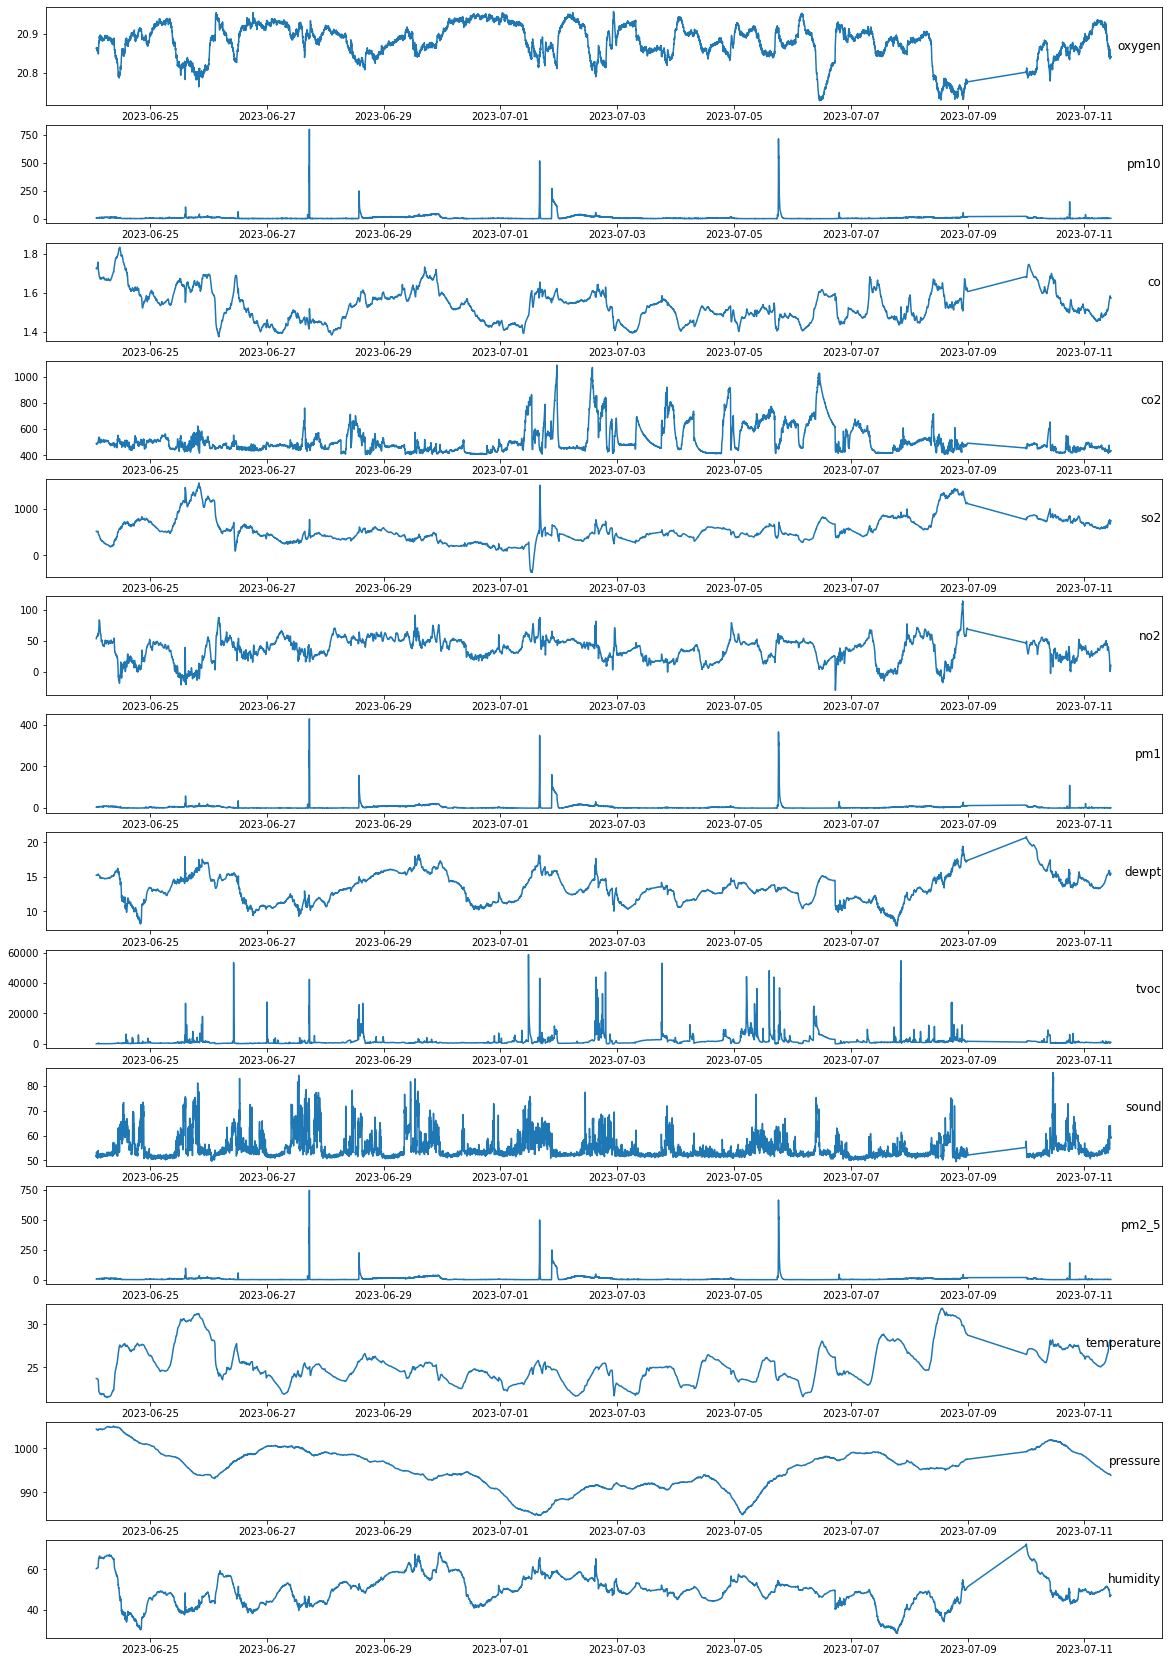

In [38]:
values = data.values
dates = data.index
groups = [0, 1, 2, 3, 4, 5, 6, 7 ,8 ,9 ,10 ,11 ,12, 13]
i = 1

plt.figure(figsize=(20,30))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(dates,values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()#date

In [39]:
data

,oxygen,pm10,co,co2,so2,no2,pm1,dewpt,tvoc,sound,pm2_5,temperature,pressure,humidity
date,,,,,,,,,,,,,,
2023-06-24 01:59:10,20.863,6.004,1.726,490.458,518.956,53.683,4.772,15.243,88.673,51.839,5.402,23.718,1004.360,60.385
2023-06-24 02:01:10,20.863,6.891,1.726,490.505,520.396,54.946,5.906,15.239,87.726,52.092,6.451,23.715,1004.340,60.377
2023-06-24 02:03:11,20.863,7.486,1.726,489.080,520.139,55.795,5.004,15.235,98.224,51.313,6.107,23.716,1004.320,60.358
2023-06-24 02:05:11,20.862,5.874,1.726,488.189,518.782,56.146,4.991,15.255,91.344,53.420,5.489,23.719,1004.300,60.426
2023-06-24 02:07:11,20.864,7.068,1.725,485.401,516.398,56.341,5.839,15.251,85.264,52.284,6.723,23.712,1004.280,60.435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-11 10:41:40,20.842,3.159,1.578,432.277,715.633,7.023,2.007,15.321,955.380,59.537,2.733,27.999,993.977,47.086
2023-07-11 10:43:40,20.843,2.592,1.577,433.938,723.661,8.350,1.668,15.398,977.042,59.008,2.277,28.029,993.949,47.237
2023-07-11 10:45:42,20.840,3.614,1.575,435.733,733.135,9.782,2.233,15.457,984.612,59.580,3.254,28.074,993.952,47.292


**Multivariate LSTM Predictive Modeling**

In [40]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

Les données de la série temporelle sont converties en données d'apprentissage supervisé et des étiquettes sont générées. Les variables d'entrée sont ensuite normalisées. Compte tenu des mesures de la pollution et des conditions météorologiques de l'heure précédente (t-1), nous posons le problème de l'apprentissage supervisé pour prédire la concentration de la pollution à l'heure actuelle (t).

In [41]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #  (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)] 
    agg = pd.concat(cols, axis=1)
    agg.columns = names


    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [42]:
values = data.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t)
1,0.588753,0.007486,0.763676,0.121727,0.459352,0.577556,0.011164,0.568879,0.001507,0.066676,...,0.008592,0.763676,0.121795,0.460102,0.586407,0.013817,0.568570,0.001491,0.073681,0.008636
2,0.588753,0.008592,0.763676,0.121795,0.460102,0.586407,0.013817,0.568570,0.001491,0.073681,...,0.009334,0.763676,0.119705,0.459968,0.592357,0.011707,0.568261,0.001670,0.052111,0.008175
3,0.588753,0.009334,0.763676,0.119705,0.459968,0.592357,0.011707,0.568261,0.001670,0.052111,...,0.007324,0.763676,0.118399,0.459262,0.594817,0.011677,0.569806,0.001553,0.110453,0.007348
4,0.584419,0.007324,0.763676,0.118399,0.459262,0.594817,0.011677,0.569806,0.001553,0.110453,...,0.008813,0.761488,0.114310,0.458021,0.596183,0.013661,0.569497,0.001449,0.078998,0.009000
5,0.593079,0.008813,0.761488,0.114310,0.458021,0.596183,0.013661,0.569497,0.001449,0.078998,...,0.008857,0.759300,0.112774,0.457025,0.597494,0.011978,0.569420,0.001466,0.065513,0.007897


In [43]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows // 1.25)
train = reframed.iloc[:train_samples, :]
test = reframed.iloc[train_samples:, :]

train_X, train_y = train.iloc[:, :-11].values, train.iloc[:, -11:].values
test_X, test_y = test.iloc[:, :-11].values, test.iloc[:, -11:].values

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(9384, 1, 14) (9384, 11) (2346, 1, 14) (2346, 11)


Define the LSTM model

Il y a 50 neurones dans la première couche cachée et 10 neurones dans la couche de sortie pour prédire la concentration de pollution. La dimension des données d'entrée sera de 1 pas de temps (c'est-à-dire 2 secondes) et de 13 caractéristiques.

In [44]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(11))
model.compile(loss='mae', optimizer='adam')
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                13000     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 11)                561       
Total params: 13,561
Trainable params: 13,561
Non-trainable params: 0
_________________________________________________________________
None


Training the LSTM model

Epoch 1/500
261/261 - 1s - loss: 0.1171 - val_loss: 0.0886
Epoch 2/500
261/261 - 0s - loss: 0.0739 - val_loss: 0.0685
Epoch 3/500
261/261 - 0s - loss: 0.0582 - val_loss: 0.0571
Epoch 4/500
261/261 - 0s - loss: 0.0510 - val_loss: 0.0498
Epoch 5/500
261/261 - 0s - loss: 0.0462 - val_loss: 0.0433
Epoch 6/500
261/261 - 0s - loss: 0.0433 - val_loss: 0.0422
Epoch 7/500
261/261 - 0s - loss: 0.0410 - val_loss: 0.0402
Epoch 8/500
261/261 - 0s - loss: 0.0395 - val_loss: 0.0399
Epoch 9/500
261/261 - 0s - loss: 0.0380 - val_loss: 0.0381
Epoch 10/500
261/261 - 0s - loss: 0.0365 - val_loss: 0.0375
Epoch 11/500
261/261 - 0s - loss: 0.0355 - val_loss: 0.0375
Epoch 12/500
261/261 - 0s - loss: 0.0347 - val_loss: 0.0364
Epoch 13/500
261/261 - 0s - loss: 0.0339 - val_loss: 0.0362
Epoch 14/500
261/261 - 0s - loss: 0.0335 - val_loss: 0.0352
Epoch 15/500
261/261 - 0s - loss: 0.0332 - val_loss: 0.0344
Epoch 16/500
261/261 - 0s - loss: 0.0329 - val_loss: 0.0347
Epoch 17/500
261/261 - 0s - loss: 0.0326 - val_lo

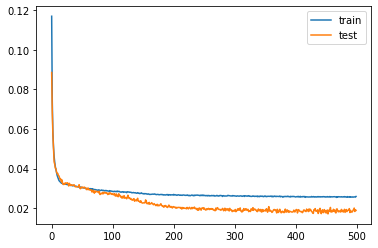

In [45]:
history = model.fit(train_X, train_y, epochs=500, batch_size=36, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Evaluating LSTM models

             0      1      2           3           4          5      6   \
2341  20.841999  3.159  1.578  432.277039  715.632935   7.023001  2.007   
2342  20.843000  2.592  1.577  433.937988  723.660950   8.350000  1.668   
2343  20.840000  3.614  1.575  435.733002  733.135010   9.781999  2.233   
2344  20.841000  2.830  1.573  432.325989  739.223999  10.519000  1.955   
2345  20.840000  3.612  1.573  433.729004  747.578003  10.958998  1.507   

             7           8          9      10  
2341  15.321000  955.380066  59.536999  2.733  
2342  15.398000  977.042053  59.008003  2.277  
2343  15.457000  984.611938  59.580002  3.254  
2344  15.481999  974.163940  59.275002  2.154  
2345  15.512000  989.638000  59.092003  1.747  


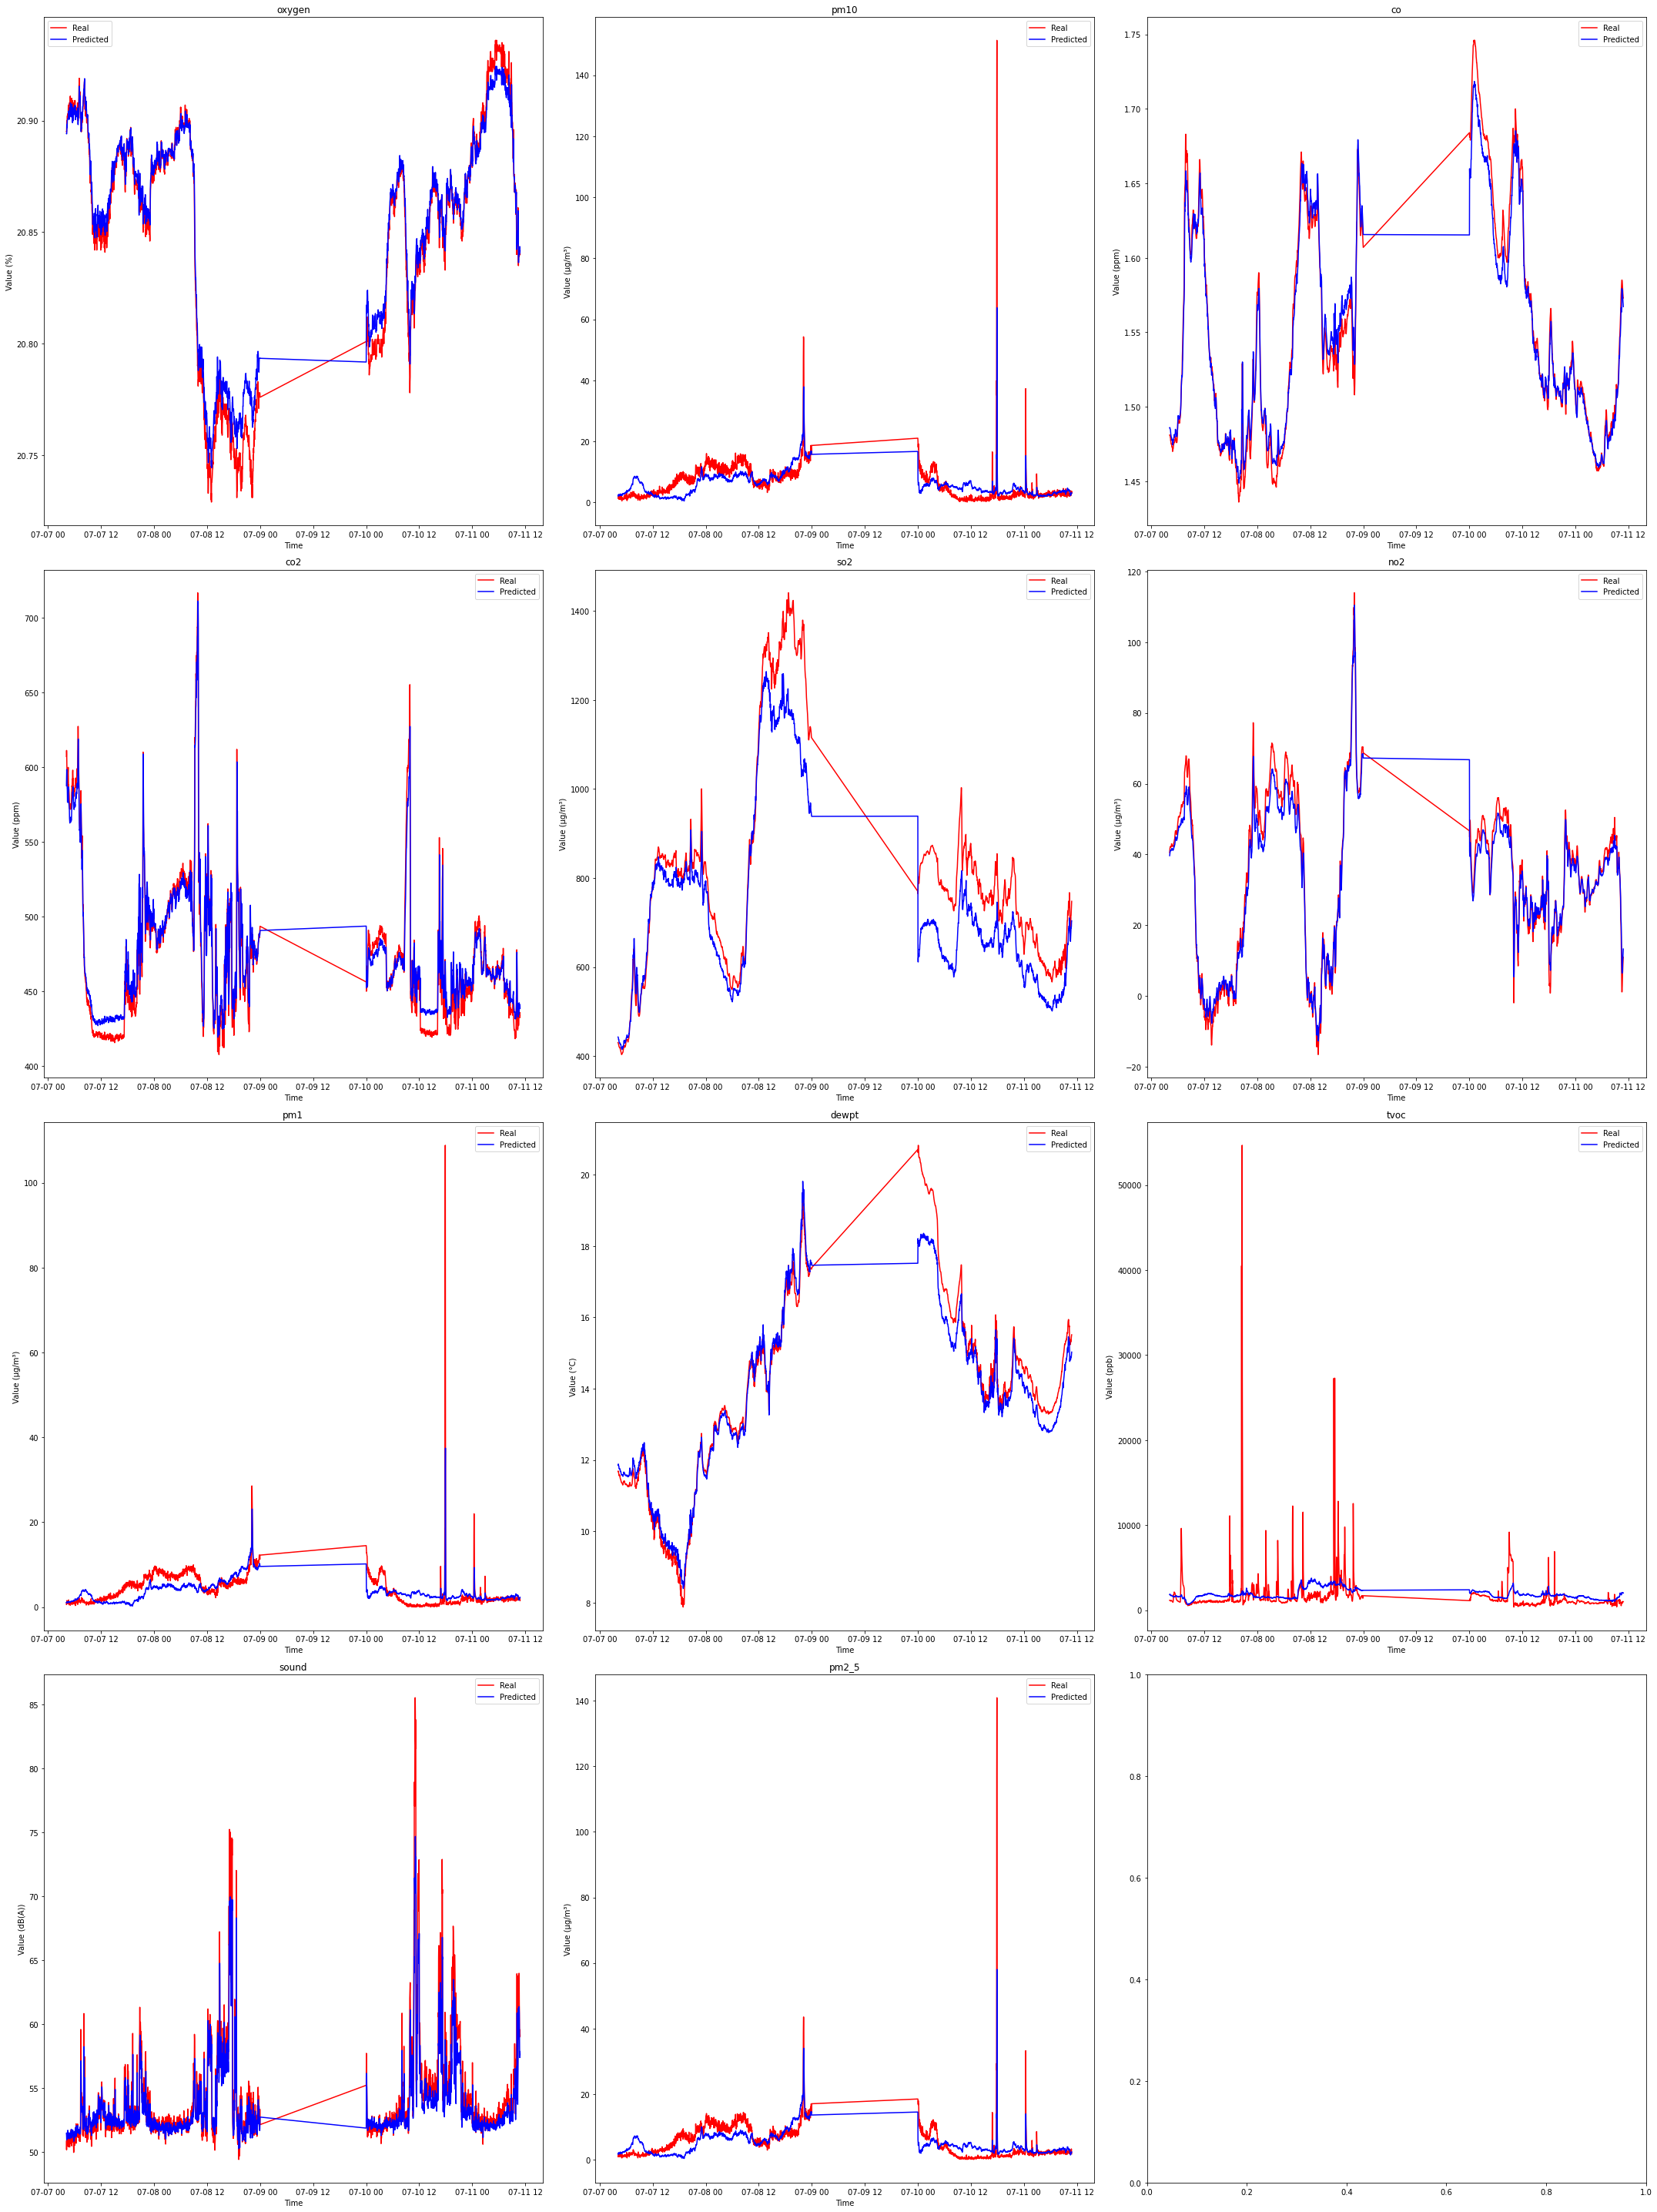

In [46]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
selected_columns = [i for i in range(test_X.shape[1]) if i in [11, 12, 13]]
# selected_columns2 = [i for i in range(test_X.shape[1]) if i not in [3, 10, 11]]
inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:-3]
# oxygen_predict = inv_yhat[:, 0]
# pm10_predict = inv_yhat[:, 1]
# co_predict = inv_yhat[:, 2]
# co2_predict = inv_yhat[:, 3]
# so2_predict = inv_yhat[:, 4]
# no2_predict = inv_yhat[:, 5]
# pm1_predict = inv_yhat[:, 6]
# dewpt_predict = inv_yhat[:, 7]
# tvoc_predict = inv_yhat[:, 8]
# pm2_5_predict = inv_yhat[:, 9]

test_y = test_y.reshape((len(test_y), 11))
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:-3]
inv_y_df = pd.DataFrame(inv_y)
print(inv_y_df.tail())
# oxygen_reel = inv_y[:, 0]
# pm10_reel = inv_y[:, 1]
# co_reel = inv_y[:, 2]
# co2_reel = inv_y[:, 3]
# so2_reel = inv_y[:, 4]
# no2_reel = inv_y[:, 5]
# pm1_reel = inv_y[:, 6]
# dewpt_reel = inv_y[:, 7]
# tvoc_reel = inv_y[:, 8]
# pm2_5_reel = inv_y[:, 9]

# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)
dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'oxygen': 0, 'pm10': 1, 'co': 2, 'co2': 3, 'so2': 4,
    'no2': 5, 'pm1': 6, 'dewpt': 7, 'tvoc': 8, 'sound': 9, 'pm2_5': 10
}

feature_units = {
    'oxygen': '%', 'pm10': 'µg/m³', 'co': 'ppm', 'co2': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³', 'pm1': 'µg/m³',
    'dewpt': '°C', 'tvoc': 'ppb', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}

for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
    axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
    axs[row, col].legend()

plt.tight_layout()
plt.show()


In [47]:
print(inv_y.shape, inv_yhat.shape)
selected_columns2 = [i for i in range(test_X.shape[1]) if i not in [11, 12, 13]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]
feature_names = ['oxygen', 'pm10', 'co', 'co2', 'so2', 'no2', 'pm1', 'dewpt', 'tvoc', 'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    print(f'Test RMSE for {feature}: {rmse:.3f}')

(2346, 11) (2346, 11)
Test RMSE for oxygen: 0.009
Test RMSE for pm10: 4.662
Test RMSE for co: 0.011
Test RMSE for co2: 11.075
Test RMSE for so2: 104.665
Test RMSE for no2: 3.539
Test RMSE for pm1: 3.276
Test RMSE for dewpt: 0.542
Test RMSE for tvoc: 2278.258
Test RMSE for sound: 1.798
Test RMSE for pm2_5: 4.262


In [48]:
data['IAQ'] = (data['pm1']<=10) & (data['pm2_5']<=25) & (data['pm10']<=50) & (data['co2']<800) & (data['tvoc']<300) 
data['IAQ'] = data['IAQ'].astype(object).replace({False:'POOR', True:'GOOD'})

In [49]:
data

,oxygen,pm10,co,co2,so2,no2,pm1,dewpt,tvoc,sound,pm2_5,temperature,pressure,humidity,IAQ
date,,,,,,,,,,,,,,,
2023-06-24 01:59:10,20.863,6.004,1.726,490.458,518.956,53.683,4.772,15.243,88.673,51.839,5.402,23.718,1004.360,60.385,GOOD
2023-06-24 02:01:10,20.863,6.891,1.726,490.505,520.396,54.946,5.906,15.239,87.726,52.092,6.451,23.715,1004.340,60.377,GOOD
2023-06-24 02:03:11,20.863,7.486,1.726,489.080,520.139,55.795,5.004,15.235,98.224,51.313,6.107,23.716,1004.320,60.358,GOOD
2023-06-24 02:05:11,20.862,5.874,1.726,488.189,518.782,56.146,4.991,15.255,91.344,53.420,5.489,23.719,1004.300,60.426,GOOD
2023-06-24 02:07:11,20.864,7.068,1.725,485.401,516.398,56.341,5.839,15.251,85.264,52.284,6.723,23.712,1004.280,60.435,GOOD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-11 10:41:40,20.842,3.159,1.578,432.277,715.633,7.023,2.007,15.321,955.380,59.537,2.733,27.999,993.977,47.086,POOR
2023-07-11 10:43:40,20.843,2.592,1.577,433.938,723.661,8.350,1.668,15.398,977.042,59.008,2.277,28.029,993.949,47.237,POOR
2023-07-11 10:45:42,20.840,3.614,1.575,435.733,733.135,9.782,2.233,15.457,984.612,59.580,3.254,28.074,993.952,47.292,POOR


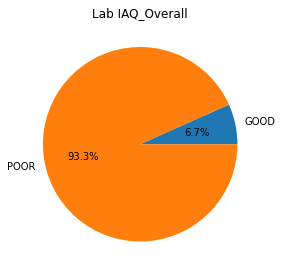

In [50]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.pie(np.unique(data['IAQ'].values, return_counts=True)[1]/len(data), labels=np.unique(data['IAQ'].values, return_counts=True)[0], autopct='%.1f%%')
ax.set_title('Lab IAQ_Overall')
plt.tight_layout()

anticiper

In [51]:
n_seconds = 7
n_features = 14

reframed = series_to_supervised(scaled, n_seconds, 1)

In [52]:
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head(10)

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var10(t-7),...,var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t)
7,0.588753,0.007486,0.763676,0.121727,0.459352,0.577556,0.011164,0.568879,0.001507,0.066676,...,0.008789,0.757112,0.115279,0.454809,0.596099,0.012343,0.569652,0.001476,0.077087,0.008455
8,0.588753,0.008592,0.763676,0.121795,0.460102,0.586407,0.013817,0.568570,0.001491,0.073681,...,0.009619,0.759300,0.115752,0.454247,0.596541,0.014250,0.570810,0.001593,0.054327,0.009624
9,0.588753,0.009334,0.763676,0.119705,0.459968,0.592357,0.011707,0.568261,0.001670,0.052111,...,0.008591,0.761488,0.119245,0.454146,0.598910,0.012694,0.571583,0.001630,0.076312,0.008112
10,0.584419,0.007324,0.763676,0.118399,0.459262,0.594817,0.011677,0.569806,0.001553,0.110453,...,0.009048,0.761488,0.119999,0.454584,0.599891,0.013036,0.570656,0.002238,0.066814,0.009314
11,0.593079,0.008813,0.761488,0.114310,0.458021,0.596183,0.013661,0.569497,0.001449,0.078998,...,0.007789,0.768053,0.121418,0.455741,0.601804,0.012603,0.571429,0.003386,0.071798,0.008089
12,0.593079,0.008857,0.759300,0.112774,0.457025,0.597494,0.011978,0.569420,0.001466,0.065513,...,0.009407,0.772429,0.125503,0.456684,0.604957,0.012919,0.571815,0.003392,0.055046,0.009522
13,0.593079,0.008218,0.759300,0.112717,0.455760,0.596975,0.012386,0.569497,0.001472,0.056209,...,0.008095,0.776805,0.123783,0.457308,0.607487,0.012776,0.572124,0.003172,0.060418,0.008471
14,0.588753,0.008789,0.757112,0.115279,0.454809,0.596099,0.012343,0.569652,0.001476,0.077087,...,0.009595,0.781182,0.132610,0.457578,0.611405,0.015163,0.574828,0.002926,0.044165,0.009887
15,0.593079,0.009619,0.759300,0.115752,0.454247,0.596541,0.014250,0.570810,0.001593,0.054327,...,0.009814,0.783370,0.134140,0.457142,0.614481,0.014709,0.575601,0.002631,0.057206,0.009942
16,0.593079,0.008591,0.761488,0.119245,0.454146,0.598910,0.012694,0.571583,0.001630,0.076312,...,0.009958,0.792123,0.131066,0.457181,0.616324,0.015106,0.575214,0.002414,0.069417,0.010300


In [53]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows // 1.25)

train = values[:train_samples, :]
test = values[train_samples:, :]
n_obs = n_seconds * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features+3:]
test_X, test_y = test[:, :n_obs], test[:, -n_features+3:]
print( train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(9384, 98) (9384, 11) (2340, 98) (2340, 11)


In [54]:
train_X = train_X.reshape((train_X.shape[0], n_seconds, n_features))
test_X = test_X.reshape((test_X.shape[0], n_seconds, n_features))

print(test_X.shape,train_X.shape)

(2340, 7, 14) (9384, 7, 14)


In [55]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(11))
model.compile(loss='mae', optimizer='adam')
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                13000     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 11)                561       
Total params: 13,561
Trainable params: 13,561
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/500
261/261 - 1s - loss: 0.1177 - val_loss: 0.0715
Epoch 2/500
261/261 - 1s - loss: 0.0696 - val_loss: 0.0542
Epoch 3/500
261/261 - 1s - loss: 0.0550 - val_loss: 0.0468
Epoch 4/500
261/261 - 1s - loss: 0.0475 - val_loss: 0.0401
Epoch 5/500
261/261 - 1s - loss: 0.0434 - val_loss: 0.0396
Epoch 6/500
261/261 - 1s - loss: 0.0409 - val_loss: 0.0391
Epoch 7/500
261/261 - 1s - loss: 0.0387 - val_loss: 0.0374
Epoch 8/500
261/261 - 1s - loss: 0.0371 - val_loss: 0.0374
Epoch 9/500
261/261 - 1s - loss: 0.0361 - val_loss: 0.0367
Epoch 10/500
261/261 - 1s - loss: 0.0354 - val_loss: 0.0362
Epoch 11/500
261/261 - 1s - loss: 0.0345 - val_loss: 0.0356
Epoch 12/500
261/261 - 1s - loss: 0.0341 - val_loss: 0.0367
Epoch 13/500
261/261 - 1s - loss: 0.0339 - val_loss: 0.0351
Epoch 14/500
261/261 - 1s - loss: 0.0339 - val_loss: 0.0346
Epoch 15/500
261/261 - 1s - loss: 0.0337 - val_loss: 0.0352
Epoch 16/500
261/261 - 1s - loss: 0.0336 - val_loss: 0.0345
Epoch 17/500
261/261 - 1s - loss: 0.0333 - val_lo

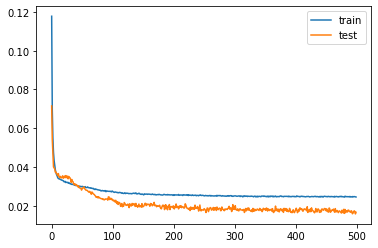

In [56]:
history = model.fit(train_X, train_y, epochs=500, batch_size=36, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

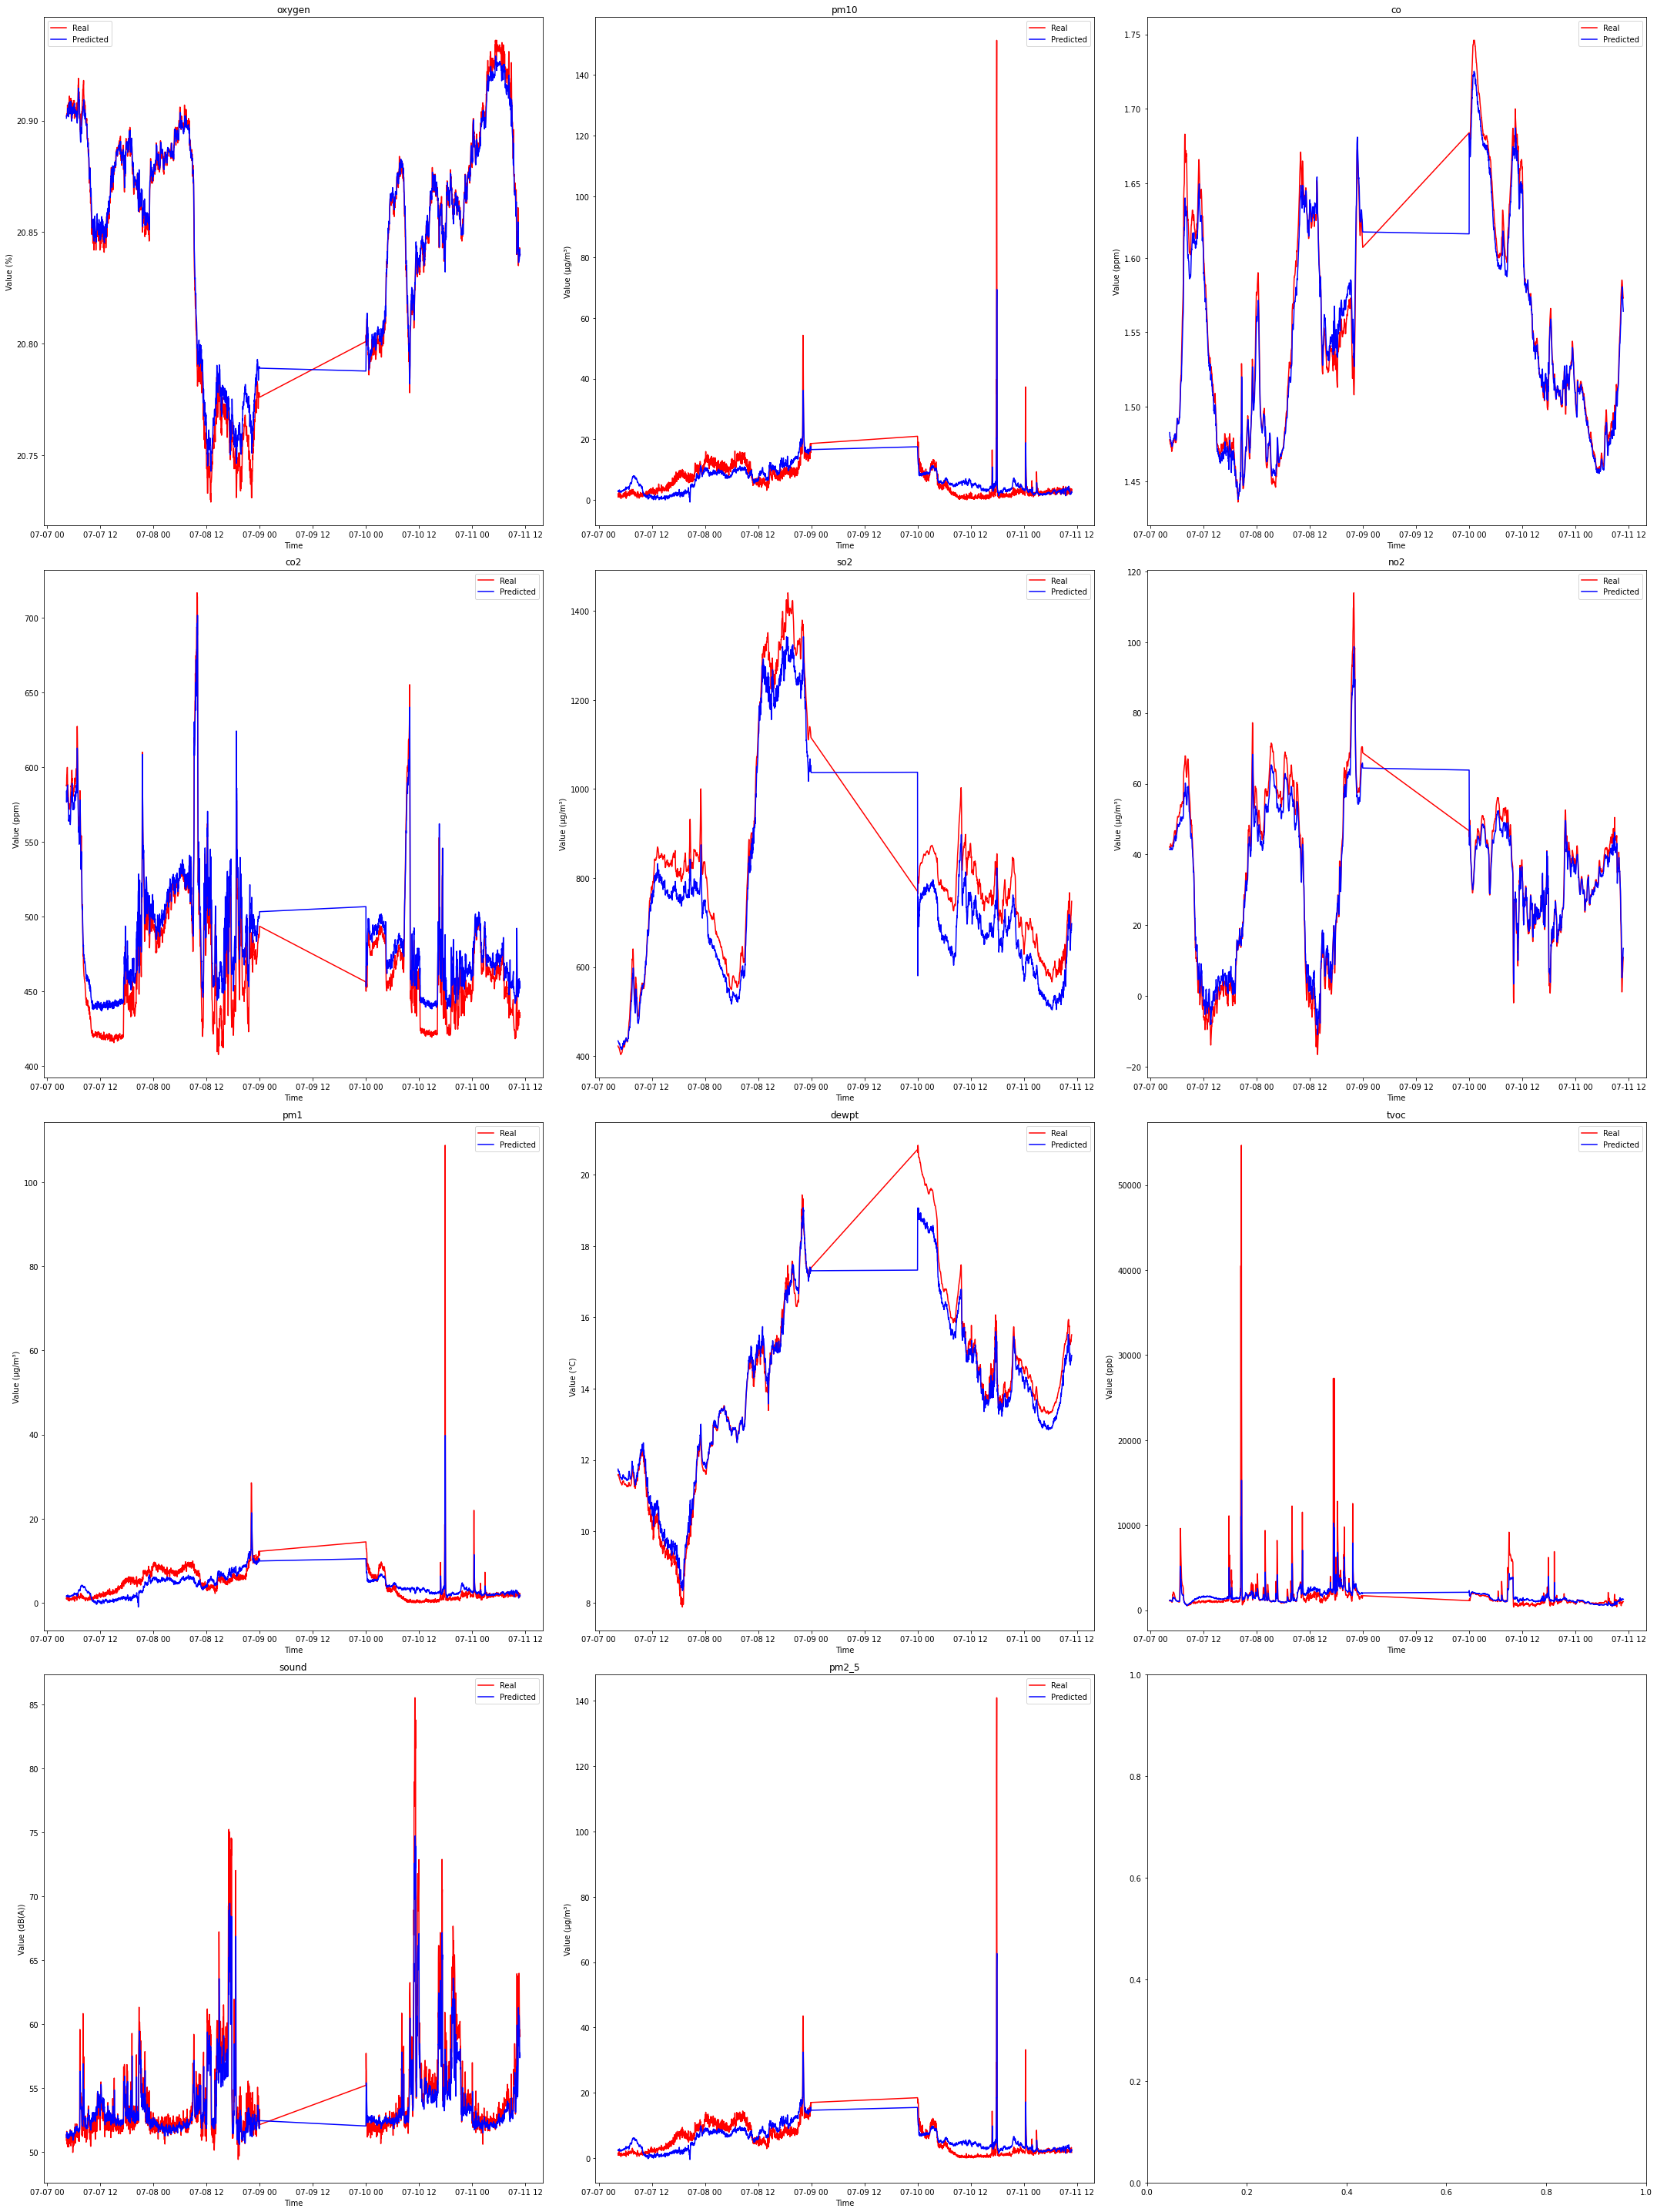

In [57]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_seconds*n_features))

selected_columns = [i for i in range(test_X.shape[1]) if i in [11, 12, 13]]

inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:, selected_columns2]

test_y = test_y.reshape((len(test_y), 11))
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:, selected_columns2]

dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'oxygen': 0, 'pm10': 1, 'co': 2, 'co2': 3, 'so2': 4,
    'no2': 5, 'pm1': 6, 'dewpt': 7, 'tvoc': 8, 'sound': 9, 'pm2_5': 10
}
feature_units = {
    'oxygen': '%', 'pm10': 'µg/m³', 'co': 'ppm', 'co2': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³', 'pm1': 'µg/m³',
    'dewpt': '°C', 'tvoc': 'ppb', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}

for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
    axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
    axs[row, col].legend()

plt.tight_layout()
plt.show()


In [58]:
print(inv_y.shape, inv_yhat.shape)

(2340, 14) (2340, 14)


In [59]:
selected_columns2 = [i for i in range(inv_y.shape[1]) if i not in [11, 12, 13]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]

In [60]:
feature_names = ['oxygen', 'pm10', 'co', 'co2', 'so2', 'no2', 'pm1', 'dewpt', 'tvoc', 'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    print(f'Test RMSE for {feature}: {rmse:.3f}')

Test RMSE for oxygen: 0.006
Test RMSE for pm10: 4.308
Test RMSE for co: 0.010
Test RMSE for co2: 17.174
Test RMSE for so2: 70.047
Test RMSE for no2: 3.570
Test RMSE for pm1: 3.007
Test RMSE for dewpt: 0.423
Test RMSE for tvoc: 1812.391
Test RMSE for sound: 1.837
Test RMSE for pm2_5: 3.944
